# Experimentos de Machine Learning - Identificação de Alimentos (Local)

Este notebook contém experimentos completos para rodar localmente no Jupyter, utilizando o dataset Food-101 do arquivo `archive (1).zip`.

## Experimentos incluídos:

1. **Extração e exploração do dataset**
2. **Preparação e pré-processamento dos dados**
3. **Classificação de imagens com scikit-learn (SVM, Random Forest)**
4. **Extração de características de imagens**
5. **Análise de resultados e visualizações**


In [1]:
# Instalar dependências necessárias (execute esta célula primeiro se houver erros de importação)
import sys
import subprocess

def install_package(package):
    """Instala um pacote usando pip"""
    subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])

# Lista de pacotes necessários
packages = [
    "numpy",
    "pandas", 
    "matplotlib",
    "seaborn",
    "pillow",
    "scikit-learn",
    "scikit-image"
]

print("Verificando e instalando dependências...")
for package in packages:
    try:
        __import__(package.replace("-", "_"))
        print(f"✓ {package} já instalado")
    except ImportError:
        print(f"Instalando {package}...")
        install_package(package)
        print(f"✓ {package} instalado com sucesso")

print("\nTodas as dependências estão prontas!")


Verificando e instalando dependências...
✓ numpy já instalado
✓ pandas já instalado
✓ matplotlib já instalado
✓ seaborn já instalado
Instalando pillow...
✓ pillow instalado com sucesso
Instalando scikit-learn...
✓ scikit-learn instalado com sucesso
Instalando scikit-image...
✓ scikit-image instalado com sucesso

Todas as dependências estão prontas!


In [2]:
# Importações necessárias
import os
import zipfile
import shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Importações do scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from skimage import feature, color, transform
from joblib import dump, load

# Configurações
SEED = 42
np.random.seed(SEED)

print(f"✓ NumPy version: {np.__version__}")
print(f"✓ Pandas version: {pd.__version__}")
print(f"✓ Matplotlib version: {plt.matplotlib.__version__}")
print(f"✓ scikit-learn disponível")
print(f"✓ scikit-image disponível")
print("\n✓ Todas as importações básicas concluídas!")


✓ NumPy version: 2.3.5
✓ Pandas version: 2.3.3
✓ Matplotlib version: 3.10.7
✓ scikit-learn disponível
✓ scikit-image disponível

✓ Todas as importações básicas concluídas!


## 1. Extração e Configuração do Dataset


In [3]:
# Configuração de caminhos
BASE_DIR = Path.cwd()
ZIP_FILE = BASE_DIR / "archive (1).zip"
ARCHIVE_DIR = BASE_DIR / "archive (1)"
IMAGES_DIR_ARCHIVE = ARCHIVE_DIR / "images"
META_DIR = ARCHIVE_DIR / "meta" / "meta"

# Verificar se há dataset alternativo
FOOD_DATASET_DIR = BASE_DIR / "Food Classification dataset"

# Priorizar dataset alternativo se existir, senão usar archive
if FOOD_DATASET_DIR.exists() and FOOD_DATASET_DIR.is_dir():
    IMAGES_DIR = FOOD_DATASET_DIR
    print(f"✓ Usando dataset alternativo: {FOOD_DATASET_DIR}")
elif IMAGES_DIR_ARCHIVE.exists():
    IMAGES_DIR = IMAGES_DIR_ARCHIVE
    print(f"✓ Usando dataset do archive: {IMAGES_DIR_ARCHIVE}")
else:
    # Tentar extrair do zip se necessário
    if ZIP_FILE.exists():
        print("Extraindo arquivo zip...")
        with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
            zip_ref.extractall(BASE_DIR)
        print("Extração concluída!")
        IMAGES_DIR = IMAGES_DIR_ARCHIVE
    else:
        IMAGES_DIR = None
        print(f"⚠️ Nenhum dataset de imagens encontrado!")

# Verificar estrutura
print(f"\nDiretório base: {BASE_DIR}")
if IMAGES_DIR:
    print(f"✓ Pasta de imagens: {IMAGES_DIR}")
    print(f"✓ Pasta de imagens existe: {IMAGES_DIR.exists()}")
    if IMAGES_DIR.exists():
        class_dirs = [d for d in IMAGES_DIR.iterdir() if d.is_dir()]
        print(f"✓ Classes encontradas: {len(class_dirs)}")
else:
    print(f"⚠️ Pasta de imagens não encontrada!")

print(f"Pasta de metadados existe: {META_DIR.exists()}")


✓ Usando dataset alternativo: c:\Users\Zion & Mariana\Desktop\Atvidades\pp4\Food Classification dataset

Diretório base: c:\Users\Zion & Mariana\Desktop\Atvidades\pp4
✓ Pasta de imagens: c:\Users\Zion & Mariana\Desktop\Atvidades\pp4\Food Classification dataset
✓ Pasta de imagens existe: True
✓ Classes encontradas: 34
Pasta de metadados existe: True


## 2. Exploração do Dataset


In [4]:
# Carregar classes
if META_DIR.exists():
    classes_file = META_DIR / "classes.txt"
    if classes_file.exists():
        with open(classes_file, 'r', encoding='utf-8') as f:
            classes = [line.strip() for line in f.readlines()]
        print(f"✓ Total de classes no arquivo: {len(classes)}")
        print(f"\nPrimeiras 10 classes: {classes[:10]}")
    else:
        print("⚠️ Arquivo classes.txt não encontrado!")
        classes = []
else:
    classes = []

# Explorar estrutura de imagens
if IMAGES_DIR and IMAGES_DIR.exists():
    class_dirs = [d for d in IMAGES_DIR.iterdir() if d.is_dir()]
    print(f"\n✓ Total de pastas de classes encontradas: {len(class_dirs)}")
    
    # Contar imagens por classe (suporta .jpg, .JPG, .jpeg, .png)
    class_counts = {}
    total_images = 0
    
    for class_dir in class_dirs:
        images = (list(class_dir.glob("*.jpg")) + 
                 list(class_dir.glob("*.JPG")) + 
                 list(class_dir.glob("*.jpeg")) + 
                 list(class_dir.glob("*.png")))
        count = len(images)
        class_counts[class_dir.name] = count
        total_images += count
    
    print(f"\n✓ Total de imagens no dataset: {total_images:,}")
    print(f"\nNúmero de imagens por classe (primeiras 15):")
    for i, (cls, count) in enumerate(list(class_counts.items())[:15]):
        print(f"  {i+1}. {cls}: {count} imagens")
    
    # Estatísticas
    if class_counts:
        avg_images = total_images / len(class_counts)
        max_images = max(class_counts.values())
        min_images = min(class_counts.values())
        print(f"\n📊 Estatísticas:")
        print(f"  - Média de imagens por classe: {avg_images:.1f}")
        print(f"  - Máximo: {max_images} imagens")
        print(f"  - Mínimo: {min_images} imagens")
    
    # Criar lista de classes disponíveis no dataset
    classes_disponiveis = list(class_counts.keys())
    print(f"\n✓ Classes disponíveis no dataset: {len(classes_disponiveis)}")
    
else:
    print("⚠️ Pasta de imagens não encontrada!")
    class_counts = {}
    classes_disponiveis = []


✓ Total de classes no arquivo: 101

Primeiras 10 classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']

✓ Total de pastas de classes encontradas: 34

✓ Total de imagens no dataset: 35,931

Número de imagens por classe (primeiras 15):
  1. apple_pie: 2000 imagens
  2. Baked Potato: 1500 imagens
  3. burger: 662 imagens
  4. butter_naan: 614 imagens
  5. chai: 688 imagens
  6. chapati: 654 imagens
  7. cheesecake: 2000 imagens
  8. chicken_curry: 2000 imagens
  9. chole_bhature: 752 imagens
  10. Crispy Chicken: 1500 imagens
  11. dal_makhani: 590 imagens
  12. dhokla: 490 imagens
  13. Donut: 1555 imagens
  14. fried_rice: 698 imagens
  15. Fries: 1500 imagens

📊 Estatísticas:
  - Média de imagens por classe: 1056.8
  - Máximo: 2000 imagens
  - Mínimo: 288 imagens

✓ Classes disponíveis no dataset: 34


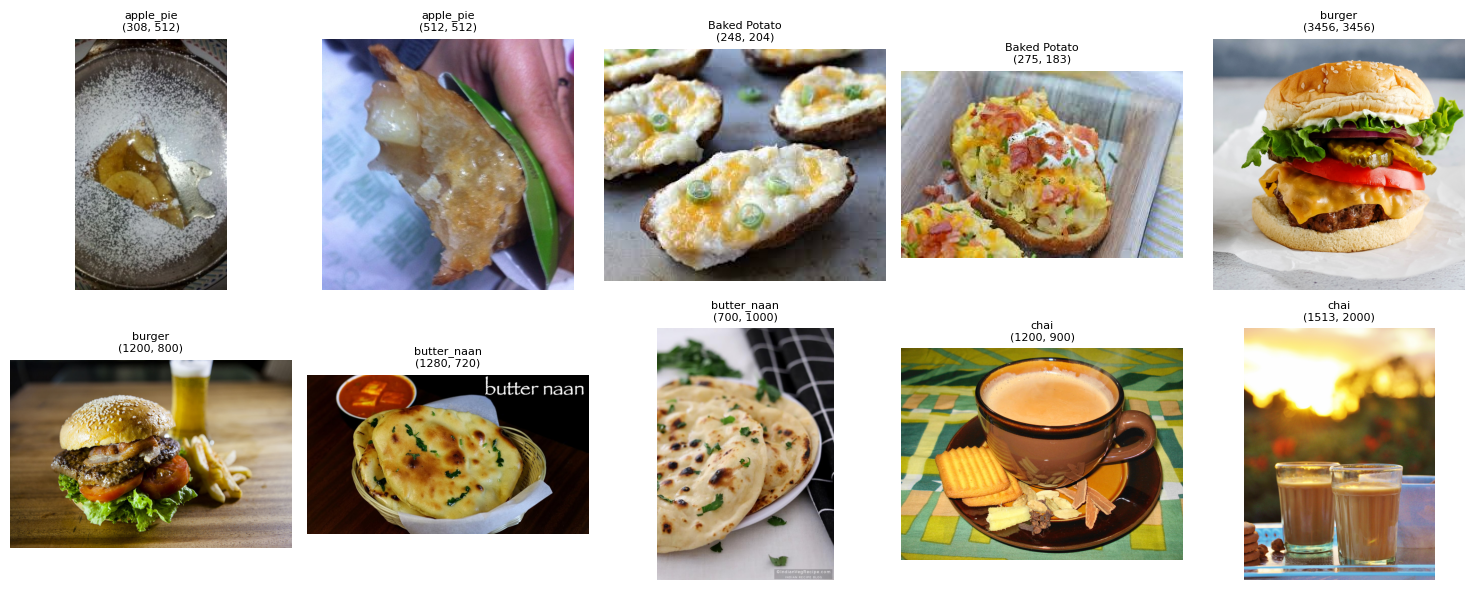


✓ Visualização de 10 imagens de exemplo


In [5]:
# Visualizar algumas imagens de exemplo
if IMAGES_DIR and IMAGES_DIR.exists():
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    
    class_dirs = [d for d in IMAGES_DIR.iterdir() if d.is_dir()][:5]
    idx = 0
    
    for class_dir in class_dirs:
        # Buscar imagens em diferentes formatos
        images = (list(class_dir.glob("*.jpg")) + 
                 list(class_dir.glob("*.JPG")) + 
                 list(class_dir.glob("*.jpeg")) + 
                 list(class_dir.glob("*.png")))[:2]
        for img_path in images:
            if idx < 10:
                try:
                    img = Image.open(img_path)
                    axes[idx].imshow(img)
                    axes[idx].set_title(f"{class_dir.name}\n{img.size}", fontsize=8)
                    axes[idx].axis('off')
                    idx += 1
                except Exception as e:
                    print(f"Erro ao carregar {img_path}: {e}")
    
    # Ocultar eixos não usados
    for i in range(idx, 10):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    print(f"\n✓ Visualização de {idx} imagens de exemplo")
else:
    print("⚠️ Não foi possível visualizar imagens - dataset não encontrado")


## 3. Preparação dos Dados


In [6]:
# Configurações para preparação dos dados
IMG_SIZE = 224  # Tamanho padrão para modelos pré-treinados
BATCH_SIZE = 32

# Para experimentos mais rápidos, vamos usar um subconjunto das classes
# Altere este valor para usar mais ou menos classes
SUBSET_CLASSES = 10  # Usar apenas 10 classes para treinamento mais rápido

# Usar classes disponíveis no dataset se existir, senão usar classes do arquivo
if 'classes_disponiveis' in locals() and classes_disponiveis:
    # Filtrar apenas classes que existem no dataset
    if classes:
        # Mapear nomes (pode ter diferenças de capitalização)
        selected_classes = []
        for cls in classes[:SUBSET_CLASSES]:
            # Buscar correspondência (case-insensitive)
            found = None
            for available_cls in classes_disponiveis:
                if cls.lower() == available_cls.lower() or cls.lower().replace('_', ' ') == available_cls.lower().replace('_', ' '):
                    found = available_cls
                    break
            if found:
                selected_classes.append(found)
            elif len(selected_classes) < SUBSET_CLASSES:
                # Se não encontrou, usar uma classe disponível
                if classes_disponiveis:
                    selected_classes.append(classes_disponiveis[len(selected_classes)])
    else:
        selected_classes = classes_disponiveis[:SUBSET_CLASSES]
    NUM_CLASSES = len(selected_classes)
    print(f"✓ Usando {len(selected_classes)} classes disponíveis no dataset para treinamento:")
    for i, cls in enumerate(selected_classes, 1):
        print(f"  {i}. {cls}")
elif classes:
    selected_classes = classes[:SUBSET_CLASSES]
    NUM_CLASSES = len(selected_classes)
    print(f"⚠️ Usando classes do arquivo (pode não corresponder ao dataset):")
    print(selected_classes)
else:
    selected_classes = []
    NUM_CLASSES = 0
    print("⚠️ Nenhuma classe disponível!")


✓ Usando 10 classes disponíveis no dataset para treinamento:
  1. apple_pie
  2. Baked Potato
  3. burger
  4. butter_naan
  5. chai
  6. chapati
  7. cheesecake
  8. chicken_curry
  9. chole_bhature
  10. Crispy Chicken


In [7]:
# Função para extrair características de imagens
def extract_features_hog(image_path, img_size=64):
    """
    Extrai características HOG (Histogram of Oriented Gradients) de uma imagem
    """
    try:
        img = Image.open(image_path)
        img = img.convert('RGB')
        img = img.resize((img_size, img_size))
        img_array = np.array(img)
        
        # Converter para escala de cinza
        gray = color.rgb2gray(img_array)
        
        # Extrair características HOG
        hog_features = feature.hog(
            gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=False
        )
        
        return hog_features
    except Exception as e:
        print(f"Erro ao processar {image_path}: {e}")
        return None

def extract_features_simple(image_path, img_size=64):
    """
    Extrai características simples (imagem redimensionada e achatizada)
    """
    try:
        img = Image.open(image_path)
        img = img.convert('RGB')
        img = img.resize((img_size, img_size))
        img_array = np.array(img) / 255.0  # Normalizar
        return img_array.flatten()
    except Exception as e:
        print(f"Erro ao processar {image_path}: {e}")
        return None

# Carregar e preparar dados
if IMAGES_DIR and IMAGES_DIR.exists() and selected_classes:
    print("Carregando imagens e extraindo características...")
    print("⚠️ Isso pode demorar alguns minutos...")
    
    X = []  # Features
    y = []  # Labels
    image_paths = []  # Caminhos das imagens
    
    # Limitar número de imagens por classe para acelerar
    MAX_IMAGES_PER_CLASS = 200
    
    for class_name in selected_classes:
        class_dir = IMAGES_DIR / class_name
        if class_dir.exists():
            images = (list(class_dir.glob("*.jpg")) + 
                     list(class_dir.glob("*.JPG")) + 
                     list(class_dir.glob("*.jpeg")) + 
                     list(class_dir.glob("*.png")))
            
            # Limitar número de imagens
            images = images[:MAX_IMAGES_PER_CLASS]
            
            print(f"Processando {class_name}: {len(images)} imagens...")
            
            for img_path in images:
                # Usar características simples (mais rápido)
                features = extract_features_simple(img_path, img_size=64)
                if features is not None:
                    X.append(features)
                    y.append(class_name)
                    image_paths.append(str(img_path))
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"\n✓ Total de amostras carregadas: {len(X)}")
    print(f"✓ Dimensão das características: {X.shape[1]}")
    print(f"✓ Classes: {len(np.unique(y))}")
    
    # Dividir em treino e validação
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )
    
    print(f"\n✓ Amostras de treino: {len(X_train)}")
    print(f"✓ Amostras de validação: {len(X_val)}")
    
    # Codificar labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_val_encoded = label_encoder.transform(y_val)
    
    class_names = label_encoder.classes_
    print(f"✓ Classes codificadas: {len(class_names)}")
    
else:
    print("⚠️ Não foi possível carregar os dados!")
    X_train = None
    X_val = None
    y_train = None
    y_val = None
    y_train_encoded = None
    y_val_encoded = None
    label_encoder = None
    class_names = None


Carregando imagens e extraindo características...
⚠️ Isso pode demorar alguns minutos...
Processando apple_pie: 200 imagens...
Processando Baked Potato: 200 imagens...
Processando burger: 200 imagens...
Processando butter_naan: 200 imagens...
Processando chai: 200 imagens...
Processando chapati: 200 imagens...
Processando cheesecake: 200 imagens...
Processando chicken_curry: 200 imagens...
Processando chole_bhature: 200 imagens...
Processando Crispy Chicken: 200 imagens...

✓ Total de amostras carregadas: 2000
✓ Dimensão das características: 12288
✓ Classes: 10

✓ Amostras de treino: 1600
✓ Amostras de validação: 400
✓ Classes codificadas: 10


## 4. Modelos de Classificação com scikit-learn


In [8]:
# Normalizar dados
if X_train is not None:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    print("✓ Dados normalizados")
    print(f"  - Forma dos dados de treino: {X_train_scaled.shape}")
    print(f"  - Forma dos dados de validação: {X_val_scaled.shape}")
    
    # Criar modelo SVM
    print("\nCriando modelo SVM...")
    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=SEED, probability=True)
    
    print("✓ Modelo SVM criado")
    print(f"  - Kernel: RBF")
    print(f"  - C: 1.0")
    
    # Criar modelo Random Forest
    print("\nCriando modelo Random Forest...")
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        random_state=SEED,
        n_jobs=-1
    )
    
    print("✓ Modelo Random Forest criado")
    print(f"  - Número de árvores: 100")
    print(f"  - Profundidade máxima: 20")
else:
    print("⚠️ Dados não disponíveis para criar modelos!")
    svm_model = None
    rf_model = None
    scaler = None


✓ Dados normalizados
  - Forma dos dados de treino: (1600, 12288)
  - Forma dos dados de validação: (400, 12288)

Criando modelo SVM...
✓ Modelo SVM criado
  - Kernel: RBF
  - C: 1.0

Criando modelo Random Forest...
✓ Modelo Random Forest criado
  - Número de árvores: 100
  - Profundidade máxima: 20


In [9]:
# Treinar modelos
if X_train_scaled is not None and y_train_encoded is not None:
    print("="*60)
    print("TREINANDO MODELO SVM")
    print("="*60)
    print("⚠️ Este processo pode demorar alguns minutos...")
    
    svm_model.fit(X_train_scaled, y_train_encoded)
    
    # Avaliar SVM
    train_pred_svm = svm_model.predict(X_train_scaled)
    val_pred_svm = svm_model.predict(X_val_scaled)
    
    train_acc_svm = accuracy_score(y_train_encoded, train_pred_svm)
    val_acc_svm = accuracy_score(y_val_encoded, val_pred_svm)
    
    print(f"\n✅ Treinamento SVM concluído!")
    print(f"  - Acurácia no treino: {train_acc_svm:.4f}")
    print(f"  - Acurácia na validação: {val_acc_svm:.4f}")
    
    print("\n" + "="*60)
    print("TREINANDO MODELO RANDOM FOREST")
    print("="*60)
    print("⚠️ Este processo pode demorar alguns minutos...")
    
    rf_model.fit(X_train_scaled, y_train_encoded)
    
    # Avaliar Random Forest
    train_pred_rf = rf_model.predict(X_train_scaled)
    val_pred_rf = rf_model.predict(X_val_scaled)
    
    train_acc_rf = accuracy_score(y_train_encoded, train_pred_rf)
    val_acc_rf = accuracy_score(y_val_encoded, val_pred_rf)
    
    print(f"\n✅ Treinamento Random Forest concluído!")
    print(f"  - Acurácia no treino: {train_acc_rf:.4f}")
    print(f"  - Acurácia na validação: {val_acc_rf:.4f}")
    
    print("\n" + "="*60)
    print("COMPARAÇÃO DE MODELOS")
    print("="*60)
    print(f"SVM - Validação: {val_acc_svm:.4f}")
    print(f"Random Forest - Validação: {val_acc_rf:.4f}")
    
else:
    print("⚠️ Dados não disponíveis para treinamento!")


TREINANDO MODELO SVM
⚠️ Este processo pode demorar alguns minutos...

✅ Treinamento SVM concluído!
  - Acurácia no treino: 0.8250
  - Acurácia na validação: 0.3100

TREINANDO MODELO RANDOM FOREST
⚠️ Este processo pode demorar alguns minutos...

✅ Treinamento Random Forest concluído!
  - Acurácia no treino: 1.0000
  - Acurácia na validação: 0.3050

COMPARAÇÃO DE MODELOS
SVM - Validação: 0.3100
Random Forest - Validação: 0.3050


RELATÓRIO DE CLASSIFICAÇÃO - SVM
                precision    recall  f1-score   support

  Baked Potato       0.31      0.20      0.24        40
Crispy Chicken       0.39      0.40      0.40        40
     apple_pie       0.11      0.10      0.10        40
        burger       0.39      0.33      0.36        40
   butter_naan       0.31      0.40      0.35        40
          chai       0.32      0.45      0.38        40
       chapati       0.21      0.25      0.23        40
    cheesecake       0.29      0.33      0.31        40
 chicken_curry       0.47      0.38      0.42        40
 chole_bhature       0.35      0.28      0.31        40

      accuracy                           0.31       400
     macro avg       0.32      0.31      0.31       400
  weighted avg       0.32      0.31      0.31       400


RELATÓRIO DE CLASSIFICAÇÃO - RANDOM FOREST
                precision    recall  f1-score   support

  Baked Potato       0.32      0.30      0.31        40
Crispy Chicken       0.

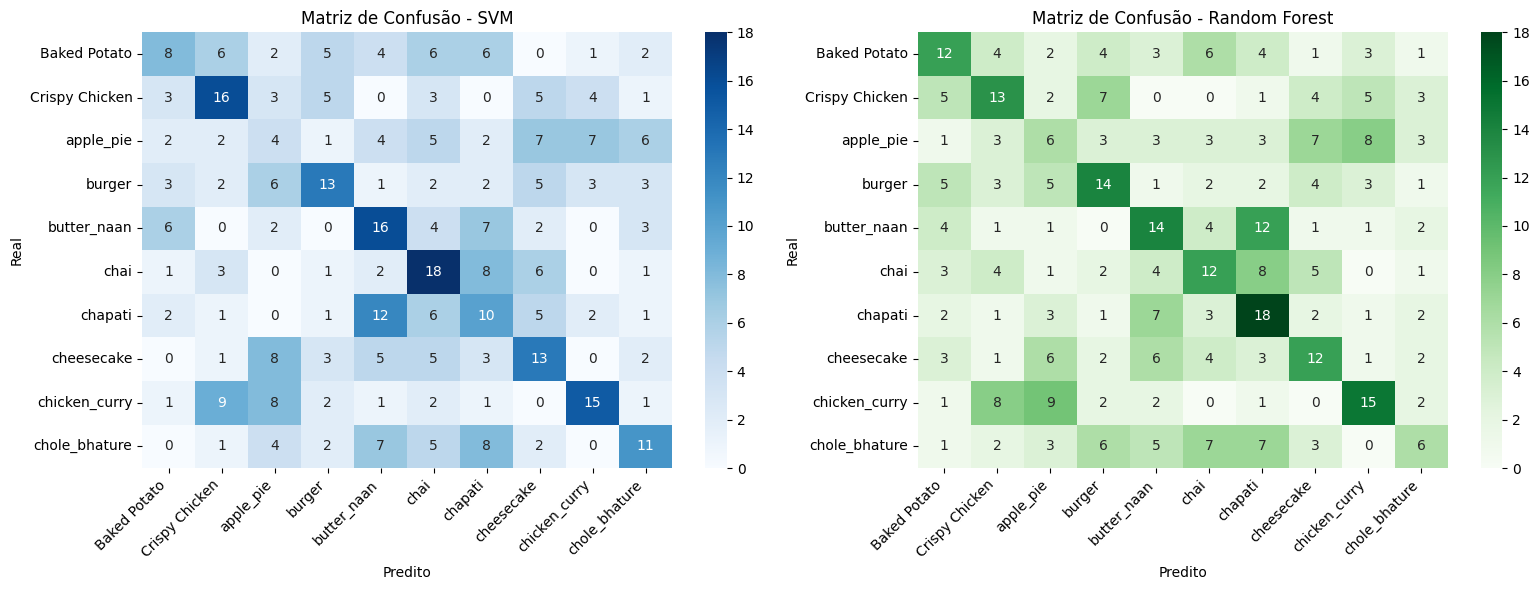

In [10]:
# Relatório de classificação detalhado
if 'val_pred_svm' in locals() and 'val_pred_rf' in locals():
    print("="*60)
    print("RELATÓRIO DE CLASSIFICAÇÃO - SVM")
    print("="*60)
    print(classification_report(y_val_encoded, val_pred_svm, target_names=class_names))
    
    print("\n" + "="*60)
    print("RELATÓRIO DE CLASSIFICAÇÃO - RANDOM FOREST")
    print("="*60)
    print(classification_report(y_val_encoded, val_pred_rf, target_names=class_names))
    
    # Matriz de confusão
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Matriz de confusão SVM
    cm_svm = confusion_matrix(y_val_encoded, val_pred_svm)
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
                xticklabels=class_names, yticklabels=class_names)
    axes[0].set_title('Matriz de Confusão - SVM')
    axes[0].set_xlabel('Predito')
    axes[0].set_ylabel('Real')
    plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')
    plt.setp(axes[0].get_yticklabels(), rotation=0)
    
    # Matriz de confusão Random Forest
    cm_rf = confusion_matrix(y_val_encoded, val_pred_rf)
    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=class_names, yticklabels=class_names)
    axes[1].set_title('Matriz de Confusão - Random Forest')
    axes[1].set_xlabel('Predito')
    axes[1].set_ylabel('Real')
    plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right')
    plt.setp(axes[1].get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Modelos não foram treinados!")


## 5. Salvar Modelos Treinados


In [11]:
# Salvar modelos treinados
MODELS_DIR = BASE_DIR / "modelos_salvos"
MODELS_DIR.mkdir(exist_ok=True)

if 'svm_model' in locals() and svm_model is not None:
    # Salvar SVM
    svm_path = MODELS_DIR / "svm_food_classifier.joblib"
    dump(svm_model, svm_path)
    print(f"✅ Modelo SVM salvo em: {svm_path}")
    
    # Salvar Random Forest
    rf_path = MODELS_DIR / "rf_food_classifier.joblib"
    dump(rf_model, rf_path)
    print(f"✅ Modelo Random Forest salvo em: {rf_path}")
    
    # Salvar scaler
    scaler_path = MODELS_DIR / "scaler.joblib"
    dump(scaler, scaler_path)
    print(f"✅ Scaler salvo em: {scaler_path}")
    
    # Salvar label encoder
    encoder_path = MODELS_DIR / "label_encoder.joblib"
    dump(label_encoder, encoder_path)
    print(f"✅ Label Encoder salvo em: {encoder_path}")
    
    # Salvar nomes das classes
    class_names_path = MODELS_DIR / "class_names.npy"
    np.save(class_names_path, class_names)
    print(f"✅ Nomes das classes salvos em: {class_names_path}")
    
    print(f"\n✓ Todos os modelos salvos em: {MODELS_DIR}")
else:
    print("⚠️ Modelos não foram treinados ainda!")


✅ Modelo SVM salvo em: c:\Users\Zion & Mariana\Desktop\Atvidades\pp4\modelos_salvos\svm_food_classifier.joblib
✅ Modelo Random Forest salvo em: c:\Users\Zion & Mariana\Desktop\Atvidades\pp4\modelos_salvos\rf_food_classifier.joblib
✅ Scaler salvo em: c:\Users\Zion & Mariana\Desktop\Atvidades\pp4\modelos_salvos\scaler.joblib
✅ Label Encoder salvo em: c:\Users\Zion & Mariana\Desktop\Atvidades\pp4\modelos_salvos\label_encoder.joblib
✅ Nomes das classes salvos em: c:\Users\Zion & Mariana\Desktop\Atvidades\pp4\modelos_salvos\class_names.npy

✓ Todos os modelos salvos em: c:\Users\Zion & Mariana\Desktop\Atvidades\pp4\modelos_salvos


In [12]:
## 6. Teste com Imagens de Exemplo


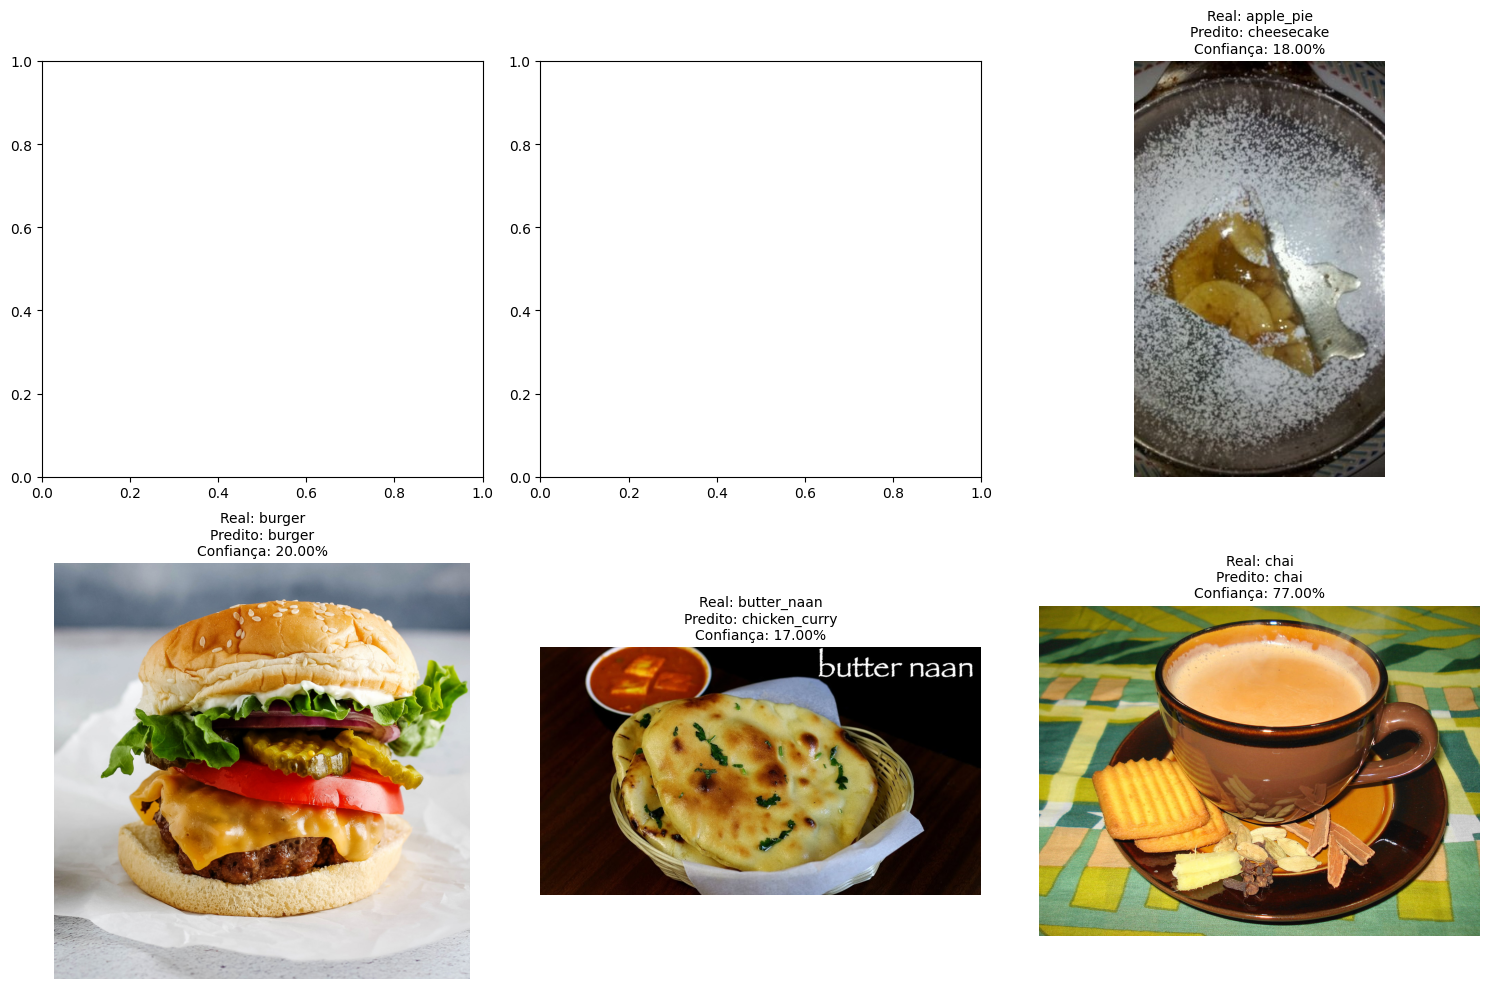


✓ Teste com imagens de exemplo concluído!


In [13]:
# Função para fazer predições em imagens
def predict_image(model, scaler, label_encoder, img_path, class_names, feature_extractor=extract_features_simple):
    """
    Faz predição em uma única imagem
    """
    # Extrair características
    features = feature_extractor(img_path, img_size=64)
    if features is None:
        return None, None, 0.0, None
    
    # Normalizar
    features_scaled = scaler.transform([features])
    
    # Predizer
    prediction = model.predict(features_scaled)[0]
    predicted_class_idx = prediction
    predicted_class = label_encoder.inverse_transform([predicted_class_idx])[0]
    
    # Probabilidades (se disponível)
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(features_scaled)[0]
        confidence = probabilities[predicted_class_idx]
    else:
        confidence = 1.0  # SVM com decision_function pode não ter probabilidades
    
    return predicted_class, confidence, probabilities if hasattr(model, 'predict_proba') else None

# Testar com algumas imagens do conjunto de validação
if 'svm_model' in locals() and svm_model is not None and IMAGES_DIR.exists():
    # Pegar algumas imagens aleatórias de cada classe
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    # Pegar uma imagem de cada classe disponível
    for idx, class_name in enumerate(class_names[:6]):
        class_dir = IMAGES_DIR / class_name
        if class_dir.exists():
            images = list(class_dir.glob("*.jpg"))
            if images:
                img_path = images[0]
                img = Image.open(img_path)
                
                # Predizer usando Random Forest (melhor para visualização)
                pred_class, confidence, probs = predict_image(
                    rf_model, scaler, label_encoder, str(img_path), class_names
                )
                
                axes[idx].imshow(img)
                title = f"Real: {class_name}\nPredito: {pred_class}\nConfiança: {confidence:.2%}"
                axes[idx].set_title(title, fontsize=10)
                axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    print("\n✓ Teste com imagens de exemplo concluído!")
else:
    print("⚠️ Modelos não disponíveis para teste!")


## 7. Resumo e Conclusões


In [14]:
# Resumo final dos experimentos
if 'val_acc_svm' in locals() and 'val_acc_rf' in locals():
    print("="*60)
    print("RESUMO DOS EXPERIMENTOS")
    print("="*60)
    print(f"\n📊 Dados:")
    print(f"  - Total de amostras: {len(X)}")
    print(f"  - Amostras de treino: {len(X_train)}")
    print(f"  - Amostras de validação: {len(X_val)}")
    print(f"  - Número de classes: {len(class_names)}")
    print(f"  - Dimensão das características: {X.shape[1]}")
    
    print(f"\n🤖 Modelos Treinados:")
    print(f"  - SVM (Support Vector Machine)")
    print(f"    * Acurácia no treino: {train_acc_svm:.4f}")
    print(f"    * Acurácia na validação: {val_acc_svm:.4f}")
    print(f"  - Random Forest")
    print(f"    * Acurácia no treino: {train_acc_rf:.4f}")
    print(f"    * Acurácia na validação: {val_acc_rf:.4f}")
    
    print(f"\n🏆 Melhor Modelo:")
    if val_acc_svm > val_acc_rf:
        print(f"  - SVM com {val_acc_svm:.4f} de acurácia")
    else:
        print(f"  - Random Forest com {val_acc_rf:.4f} de acurácia")
    
    print(f"\n💾 Modelos Salvos:")
    print(f"  - Diretório: {MODELS_DIR}")
    print(f"  - Modelos prontos para uso na aplicação!")
    print("="*60)
else:
    print("⚠️ Experimentos não foram executados completamente!")


RESUMO DOS EXPERIMENTOS

📊 Dados:
  - Total de amostras: 2000
  - Amostras de treino: 1600
  - Amostras de validação: 400
  - Número de classes: 10
  - Dimensão das características: 12288

🤖 Modelos Treinados:
  - SVM (Support Vector Machine)
    * Acurácia no treino: 0.8250
    * Acurácia na validação: 0.3100
  - Random Forest
    * Acurácia no treino: 1.0000
    * Acurácia na validação: 0.3050

🏆 Melhor Modelo:
  - SVM com 0.3100 de acurácia

💾 Modelos Salvos:
  - Diretório: c:\Users\Zion & Mariana\Desktop\Atvidades\pp4\modelos_salvos
  - Modelos prontos para uso na aplicação!


## Notas Finais

### Dicas para melhorar os resultados:

1. **Aumentar número de classes**: Altere `SUBSET_CLASSES` para usar mais classes
2. **Aumentar número de imagens**: Aumente `MAX_IMAGES_PER_CLASS` para mais dados
3. **Extrair mais características**: Use HOG ou combine múltiplas características
4. **Ajustar hiperparâmetros**: Experimente diferentes valores de C, gamma (SVM) ou n_estimators (RF)
5. **Tamanho da imagem**: Experimente diferentes tamanhos (32, 64, 128)
6. **Usar PCA**: Reduza dimensionalidade para acelerar treinamento

### Próximos passos:

- Experimentar com outras características (LBP, SIFT, etc.)
- Implementar ensemble de modelos
- Adicionar data augmentation
- Testar com mais classes do dataset
